# Deep Q Learning

#### Can I take the findings from Q-Learning, and extend it to a deep learning framework?

In [1]:
# For some reason, importing this first doesn't crash the kernel

import torch
torch.manual_seed(0)

In [22]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Custom Modules.
from src.modules.game import Game

from src.deep_learning.modules import Net, Trainer

from src.deep_learning.utils.viz import gen_value_tensor, gen_action_tensor, plot_mesh, gen_all_states, show_action_table
from src.deep_learning.utils.play import create_state_action

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [23]:
rules = {
    "dealer_hit_soft17": False,
    "push_dealer22": False,
    "double_after_split": True,
    "hit_after_split_aces": False,
    "reduced_blackjack_payout": False,
    "allow_surrender": True,
    "split_any_ten": True,
}

game_hyperparams = {
    "shrink_deck": True,
    "n_decks": 6,
    "ratio_penetrate": 2/3,
    "rules": rules
}

## Deep Q Learning

The Q learning without without Neural Networks is found in my previous notebook. While we determine the Q function explicitly, this requires access to all state-action pairs.

---

In Deep Q Learning, we are approximating the Q function through use of linear + non-linear layers in a neural network, attempting to minimize MSE (I actually use Huber Loss) between Temporal Difference Q values of current and future states. We will ultimately be regressing the Q value for each possible action for a given state.

As proposed by Deepmind, we make use of a **target network** and a **q network**.

This is because, we are otherwise chasing a non-stationary target in the Q(s,a) values.

Given state $s$, we use the **q network** to compute the $Q(s,a)$ values for each action. At the same time, the **target network** uses the next state $s`$ to compute $Q(s`,a)$ for the TD target. $Q(s`,a)$ doesn't always have meaning, as taking an action in $s$ might lead us to a terminal state. In this instance, we simply look at the reward. After $M$ rounds, we copy the parameters of the **q network** over to the **target network**.
 
We can implement **experience replay**, where we store the agent's past experience in a deque and sample from this during training. So, in each epoch, simulate a round of gameplay, and store the following, there are 2 means of doing this. I'll touch on this in the **Action Masking** section.

---

### Model Inputs

$$(player\_total, house\_shows, useable\_ace, can\_split, can\_double)$$

### Action Masking
I want a way to implement action masking. I need this because not every action is accessible from every state. I can try this 2 different ways:
- Explicitly mask outputs based on state. Constrain the action space to only valid actions.
- Implicitly learn this mask by penalizing outcomes that select an invalid action. I've found that too severe of penalties, experienced early in training during exploration, makes it incredibly hard to recover these later on. Small negative rewards are given to these.


#### Explicit Masking
My first attempt at handling this is by explicitly doing action masking for both **target network** and **q network**, where I have access to possible actions, and I can mask invalid ones by forcing model outputs to $-inf$. This will have the impact that in both $argmax$ and $softmax$, they will be unreachable actions and will never be used for $Q(s`,a)$ or $Q(s,a)$ action selections. Until I find a better method for this, I don't particularly like it. $Q(s,a)$ values for unreachable states are quite high even for unreachable states, and it seems to pull from the actual meaningful $Q(s,a)$ values for valid states. Remember, we still produce Q values for these invalid states in the `forward()` pass, they are just masked downstream.

$$(state, possible\_actions, action, reward, done, new\_state, possible\_actions\_new)$$


#### Implicit Masking
My next approach is to implicitly penalize selections to invalid states. Given that $can\_split, can\_double$ are parts of the input space, the network should feasibly be able to differentiate when it can and cannot split + double. In the replay buffer, if we select an invalid action, we immediately stop gameplay simulation and add a response with a negative reward. I'll call this the **misstep** penalty, and it's actually a rather important hyperparameter to adjust.

$$(state, action, reward, done, new\_state)$$

In [24]:
def get_decay_factor(max_val, min_val, n):
    return np.log(max_val / min_val) / n

def get_current_decay_value(max_val, decay_factor, n):
    return max_val * np.exp(-decay_factor * n)

REPLAY_SIZE = 10_000
MIN_REPLAY_SIZE = 1_000 # this won't be hit exactly due to splitting during gameplay.
GAMMA = 0.99
LR = 0.0001
TARGET_UPDATE_FREQ = 1_000
N_EPOCHS = 1_000_000
EVAL_EVERY = 10_000
BATCH_SIZE = 32

EPS_MIN = .1

EPS_DECAY = get_decay_factor(1, EPS_MIN, N_EPOCHS)

USE_COUNT = False

In [25]:
hidden_layers = [100, 50]

In [26]:
online_net = Net(5, hidden_layers=hidden_layers, allow_surrender=True)
target_net = Net(5, hidden_layers=hidden_layers, allow_surrender=True)

trainer = Trainer(
    online_net=online_net,
    target_net=target_net,
    lr=LR,
    replay_size=REPLAY_SIZE,
    include_count=USE_COUNT
)

trainer.copy_online_to_target()

In [27]:
blackjack = Game(**game_hyperparams)

mean_rewards = []
training_loss = []

replay_sufficient = False

for step in range(N_EPOCHS):
    print(f"Round {step}", end="\r")

    eps = get_current_decay_value(1, EPS_DECAY, step)

    if not replay_sufficient:
        replay_sufficient = len(trainer.replay_buffer) >= MIN_REPLAY_SIZE

    if not replay_sufficient:
        method = "random"
    else:
        method = "random" if np.random.sample() < eps else "argmax"
        # method = "softmax" # can comment this out if you which to use epsilon-greedy

    trainer.update_buffer(blackjack=blackjack, method=method)

    # ensure that our replay buffer size is sufficient before training.
    if not replay_sufficient: continue

    loss_epoch = trainer.train_epoch(batch_size=BATCH_SIZE, gamma=GAMMA)

    training_loss.append(loss_epoch)

    if not step % TARGET_UPDATE_FREQ:
        trainer.copy_online_to_target()

    if (not step % EVAL_EVERY) or (step + 1 == N_EPOCHS):
        mean_reward = await trainer.eval(
            n_games=100,
            n_rounds=50,
            wagers=[1],
            game_hyperparams=game_hyperparams
        )
        mean_rewards.append(mean_reward)
        print(f"step {step}\
 ---- mean reward per round {mean_reward:.4f}\
 ---- epoch training loss {loss_epoch:.4f}\
 ---- eps {eps:.4f}")

network = Net(5, hidden_layers=hidden_layers, allow_surrender=True)

network.load_state_dict(deepcopy(trainer.online_net.state_dict()))
network.eval()

step 10000 ---- mean reward per round -0.0248 ---- epoch training loss 0.4456 ---- eps 0.9772
step 20000 ---- mean reward per round -0.0600 ---- epoch training loss 0.2468 ---- eps 0.9550
step 30000 ---- mean reward per round -0.0401 ---- epoch training loss 0.1809 ---- eps 0.9333
step 40000 ---- mean reward per round -0.0473 ---- epoch training loss 0.5230 ---- eps 0.9120
step 50000 ---- mean reward per round -0.0434 ---- epoch training loss 0.4237 ---- eps 0.8913
step 60000 ---- mean reward per round -0.0336 ---- epoch training loss 0.3657 ---- eps 0.8710
step 70000 ---- mean reward per round -0.0463 ---- epoch training loss 0.1917 ---- eps 0.8511
step 80000 ---- mean reward per round -0.0377 ---- epoch training loss 0.3356 ---- eps 0.8318
step 90000 ---- mean reward per round -0.0511 ---- epoch training loss 0.2856 ---- eps 0.8128
step 100000 ---- mean reward per round -0.0346 ---- epoch training loss 0.3879 ---- eps 0.7943
step 110000 ---- mean reward per round -0.0199 ---- epoch t

Net(
  (fc_input): Linear(in_features=5, out_features=100, bias=True)
  (fc_hidden): ModuleList(
    (0): Linear(in_features=100, out_features=50, bias=True)
  )
  (fc_output): Linear(in_features=50, out_features=5, bias=True)
)

In [28]:
torch.save(network.state_dict(), "./models/deep_q.pt")

In [29]:
network =  Net(5, hidden_layers=hidden_layers, allow_surrender=True)
network.load_state_dict(torch.load("./models/deep_q.pt"))
network.eval()

Net(
  (fc_input): Linear(in_features=5, out_features=100, bias=True)
  (fc_hidden): ModuleList(
    (0): Linear(in_features=100, out_features=50, bias=True)
  )
  (fc_output): Linear(in_features=50, out_features=5, bias=True)
)

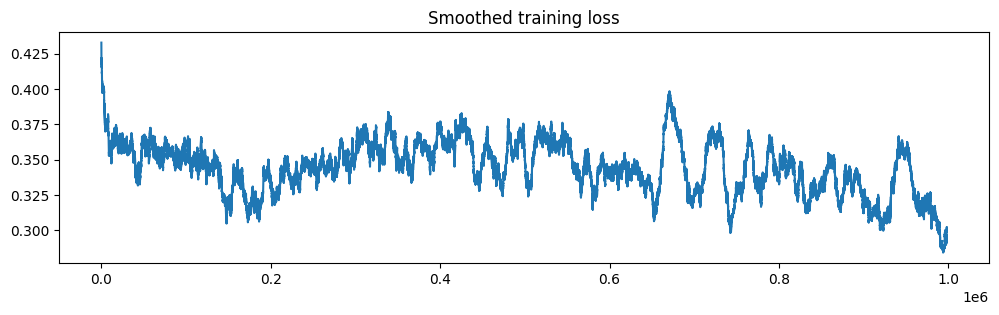

In [30]:
plt.figure(figsize=(12,3))
plt.plot(np.convolve(training_loss, np.ones(1000)/1000, mode="valid"))
plt.title("Smoothed training loss")
# plt.vlines(range(len(training_loss))[::1000], ymin=.25, ymax=.55)
plt.show()

In [31]:
all_states = gen_all_states(include_count=False)


no_ace_no_split = list(filter(lambda x : (x[2] < 0) and (x[3] < 0) and (x[4] > 0), all_states))
yes_ace_no_split = list(filter(lambda x : (x[2] > 0) and (x[3] < 0) and (x[4] > 0), all_states))
yes_split = list(filter(lambda x : (x[3] > 0), all_states))

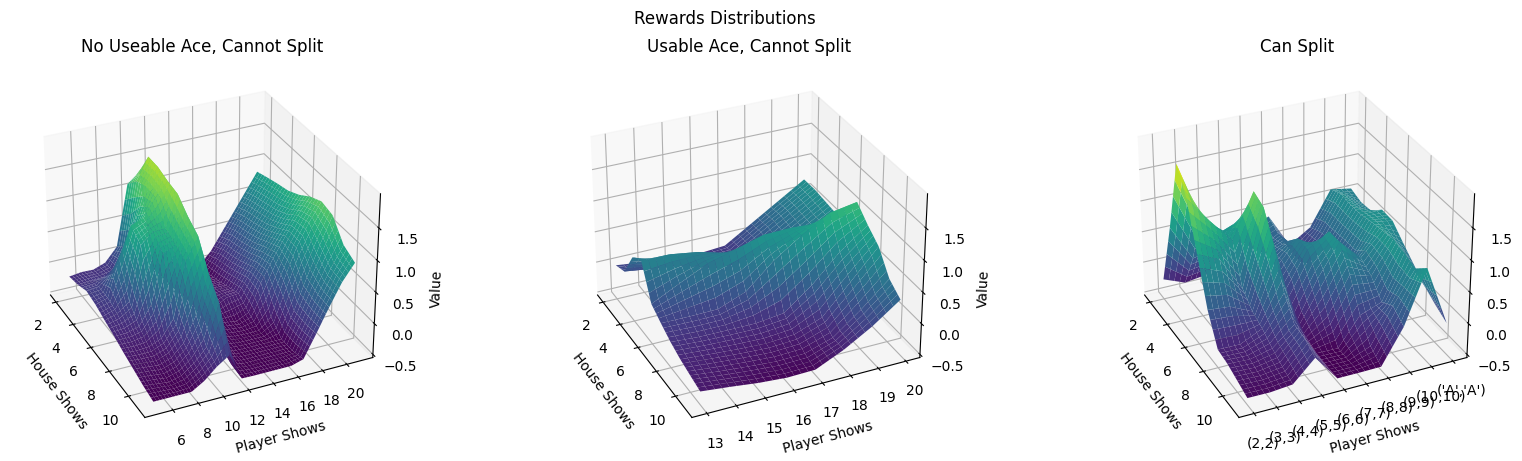

In [32]:
value_det_0, min_0, max_0 = gen_value_tensor(model=network, data=no_ace_no_split, avail_actions=["hit", "stay", "double", "surrender"])
value_det_1, min_1, max_1 = gen_value_tensor(model=network, data=yes_ace_no_split, avail_actions=["hit", "stay", "double", "surrender"])
value_det_2, min_2, max_2 = gen_value_tensor(model=network, data=yes_split, avail_actions=["hit", "stay", "double", "split", "surrender"])


min_use = np.min([min_0, min_1, min_2])
max_use = np.max([max_0, max_1, max_2])


fig = plt.figure(figsize=(20,5))
fig.suptitle("Rewards Distributions")
ax = fig.add_subplot(131, projection="3d")
ax.set_title("No Useable Ace, Cannot Split")

plot_mesh(
    axis=ax,
    data=value_det_0,
    interpolate=4,
    ticks=None,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

ax = fig.add_subplot(132, projection="3d")
ax.set_title("Usable Ace, Cannot Split")

plot_mesh(
    axis=ax,
    data=value_det_1,
    interpolate=4,
    ticks=None,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

ax = fig.add_subplot(133, projection="3d")
ax.set_title("Can Split")

ticks = [f"({p},{p})" if p < 11 else "('A','A')" for p in range(2,12)]
plot_mesh(
    axis=ax,
    data=value_det_2,
    interpolate=4,
    ticks=ticks,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

In [33]:
value_action = gen_action_tensor(model=network, data=no_ace_no_split, avail_actions=["hit", "stay", "double", "surrender"])

print("No Useable Ace, Can't Split")
show_action_table(value_action)

No Useable Ace, Can't Split


,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,St,St,Hi,Hi,Hi,Hi,Su
6,Hi,Hi,Hi,Hi,St,St,Hi,Hi,Hi,Su
7,Hi,Hi,Do/Hi,Do/Hi,Do/Hi,St,St,Hi,Hi,Su
8,Hi,Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Su
9,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi
10,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi
11,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi
12,Hi,Hi,St,Hi,Hi,Hi,Hi,Hi,Hi,Hi
13,Hi,Hi,St,St,Hi,Hi,Hi,Hi,Su,Su
14,Hi,Hi,St,St,Hi,Hi,Hi,Su,Su,Su


In [34]:
value_action = gen_action_tensor(model=network, data=yes_ace_no_split, avail_actions=["hit", "stay", "double", "surrender"])

print("Yes Useable Ace, Can't Split")
show_action_table(value_action)

Yes Useable Ace, Can't Split


,2,3,4,5,6,7,8,9,10,11
13,Hi,Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi,Hi
14,Hi,Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
15,Hi,Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
16,Hi,Hi,Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi
17,St,Hi,Hi,Do/Hi,Do/Hi,Do/St,Hi,Hi,Hi,Hi
18,St,St,St,Do/St,Do/St,Do/St,St,St,St,St
19,St,St,St,St,Do/St,Do/St,St,St,St,St
20,St,St,St,St,St,Do/St,St,St,St,St


In [35]:
value_action = gen_action_tensor(model=network, data=yes_split, avail_actions=["hit", "stay", "double", "split", "surrender"])

print("Can Split")
show_action_table(value_action, xticks=[(p,p) if p < 11 else ("A","A") for p in range(2,12)])

Can Split


,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Hi,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi
"(3, 3)",Hi,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi
"(4, 4)",Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi
"(6, 6)",Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Su,Su
"(7, 7)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Su,Su
"(8, 8)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(9, 9)",St,St,St,St,St,Sp,Sp,St,St,St
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Do,Do,Sp,Sp,Sp,Sp,Sp,Sp


In [41]:
player.cards[0].cards

[Card(suit=<SuitEnum.hearts: 'h'>, card=3),
 Card(suit=<SuitEnum.clubs: 'c'>, card=5)]

In [48]:
blackjack = Game(**game_hyperparams)

network.eval()
    
blackjack.init_round([1])
blackjack.deal_init()

player = blackjack.players[0]

house_card_show = blackjack.get_house_show()
house_value = house_card_show.value if house_card_show.value > 1 else 11

print("HOUSE SHOWS", house_card_show.card)

while not player.is_done():
    observations, move, policy = create_state_action(
        player=player,
        house_show=house_value,
        include_count=USE_COUNT,
        true_count=blackjack.true_count,
        model=network,
        method="argmax"
    )

    print("PLAYER", [card.card for card in player.cards[0].cards], policy, observations, move)

    blackjack.step_player(0, move)

blackjack.step_house(only_reveal_card=True)
while not blackjack.house_done():
    blackjack.step_house()
players_text, players_winnings = blackjack.get_results()

print()
print("PLAYER", [card.card for card in player.cards[0].cards])
print()
print("HOUSE", [card.card for card in blackjack.house.cards[0].cards], blackjack.house.cards[0].total)

print(sum(players_winnings[0]), players_text)

HOUSE SHOWS 3
PLAYER [7, 10] ['stay', 'hit', 'surrender', 'double'] (17, 3, -1, -1, 1) stay

PLAYER [7, 10]

HOUSE [3, 9, 8] 20
-1 [['loss']]


In [49]:
ar = yes_split
action_space = ["hit", "stay", "double", "surrender", "split"]

actions = [action_space for _ in ar]
with torch.no_grad():
    q, _, action = network.act(torch.tensor(ar, dtype=torch.float32), method="argmax", avail_actions=actions)

for i,r in enumerate(q):
    print(ar[i], r, network.moves[action[i]])

(4, 2, -1, 1, 1) tensor([-0.7704, -0.2242, -1.9802, -0.2768, -0.4998]) hit
(4, 3, -1, 1, 1) tensor([-0.5233, -0.1298, -1.5307,  0.7958, -0.4993]) split
(4, 4, -1, 1, 1) tensor([-0.2747, -0.2221, -0.8772,  1.9650, -0.4987]) split
(4, 5, -1, 1, 1) tensor([-0.3555, -0.2837, -0.6147,  1.5971, -0.4987]) split
(4, 6, -1, 1, 1) tensor([-0.4376, -0.2774, -0.7924,  0.8990, -0.4988]) split
(4, 7, -1, 1, 1) tensor([-0.5184, -0.2658, -1.0183,  0.1896, -0.4989]) split
(4, 8, -1, 1, 1) tensor([-0.6226, -0.2570, -1.4619, -0.5283, -0.4990]) hit
(4, 9, -1, 1, 1) tensor([-0.7259, -0.2933, -1.7707, -0.9824, -0.4990]) hit
(4, 10, -1, 1, 1) tensor([-0.8325, -0.3653, -1.9481, -1.2197, -0.4990]) hit
(4, 11, -1, 1, 1) tensor([-0.9397, -0.4400, -2.1393, -1.4517, -0.4990]) hit
(6, 2, -1, 1, 1) tensor([-0.7678, -0.3628, -1.6803, -0.5179, -0.5005]) hit
(6, 3, -1, 1, 1) tensor([-0.6542, -0.1833, -1.3065,  0.2169, -0.5005]) split
(6, 4, -1, 1, 1) tensor([-0.4610, -0.0362, -1.2352,  1.0426, -0.5001]) split
(6, 5, -1